In [19]:
import torch
from core.kernel import NeuralKernel
import core.GP_CommonCalculation as GP
from data_sample import generate_example_data as data
from core.autoGP import autoGP

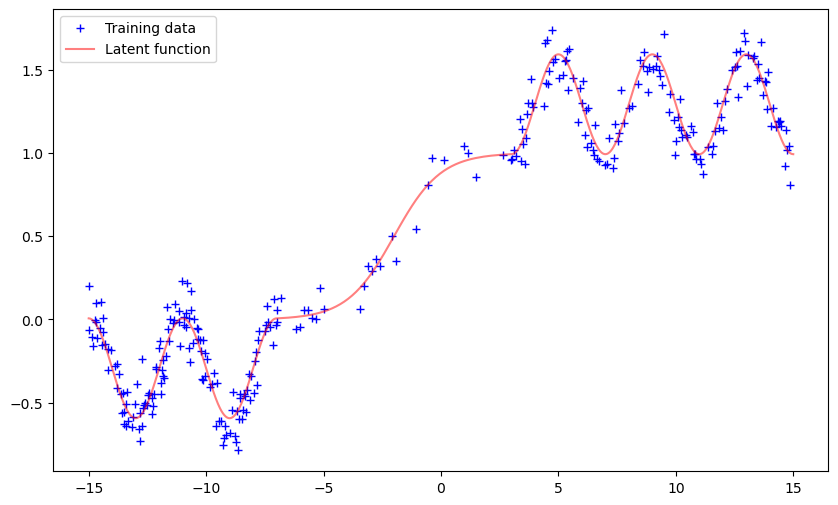

In [20]:
xtr, ytr, xte, yte, x_combined, y_combined = data.generate_complex_data(600, seed=1)

data.plot(xtr, ytr, x_combined, y_combined)

In [21]:
device = torch.device('cuda')
xtr, ytr, xte, yte = xtr.to(device), ytr.to(device), xte.to(device), yte.to(device)

# Normalize the data outside the model
normalizer = GP.DataNormalization(method='min_max').to(device)
normalizer.fit(xtr, 'x')
normalizer.fit(ytr, 'y')
normalizer.fit(xte, 'xte')
xtr_normalized = normalizer.normalize(xtr, 'x')
ytr_normalized = normalizer.normalize(ytr, 'y')
xte_normalized = normalizer.normalize(xte, 'xte')

In [22]:
model = autoGP(input_dim=xtr_normalized.size(1), device=device, kernel=NeuralKernel, inputwarp=False,
               deepkernel=False).to(device)

model.train_auto(xtr_normalized, ytr_normalized)

AutoGP training completed in 5.17 seconds


In [23]:
mean, var = model.forward(xtr_normalized, ytr_normalized, xte_normalized)
mean = normalizer.denormalize(mean, 'y')
var = normalizer.denormalize_cov(var, 'y')

MSE for autoGP: 0.003164923737775443


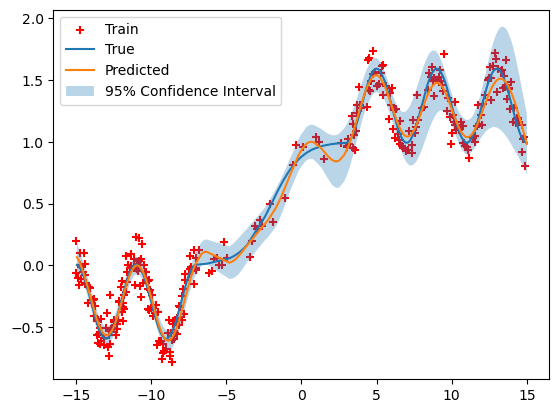

In [27]:
mse = torch.mean((mean - yte) ** 2)
print(f'MSE for autoGP: {mse.item()}')

# Sort xte and get the sorted indices
sorted_indices = torch.argsort(xte.squeeze())

# Apply the sorted indices to xte, ypred, and yvar
xte_sorted = xte[sorted_indices]
yte_sorted = yte[sorted_indices]
mean_sorted = mean[sorted_indices]
yvar_sorted = var[sorted_indices]
std_sorted = torch.sqrt(yvar_sorted)
import matplotlib.pyplot as plt

plt.scatter(xtr.cpu().numpy(), ytr.cpu().numpy(), color='r',label='Train',marker='+')
plt.plot(xte_sorted.cpu().numpy(), yte_sorted.cpu().numpy(), label='True')
plt.plot(xte_sorted.cpu().numpy(), mean_sorted.detach().cpu().numpy(), label='Predicted')

plt.fill_between(xte_sorted.cpu().numpy().squeeze(), (mean_sorted - 1.96 * std_sorted).cpu().detach().numpy().squeeze(),
                 (mean_sorted + 1.96 * std_sorted).cpu().detach().numpy().squeeze(), alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.show()